In [1]:
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.models import load_model

import matplotlib.pyplot as plt
import cv2


Using TensorFlow backend.


In [2]:
model_path = "./model_data/yolo-voc.h5"
yolo_model = load_model(model_path)

yolo_model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 416, 416, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 416, 416, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 416, 416, 32)  128         convolution2d_1[0][0]            
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 416, 416, 32)  0           batchnormalization_1[0][0]       
___________________________________________________________________________________________

C:\Continuum\Anaconda3\lib\site-packages\keras\models.py:150: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
anchors = [[1.08, 1.19], [3.42, 4.41], [6.63, 11.38], [9.42, 5.11], [16.62, 10.52]]
class_names = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

In [4]:
# imagePath = './images/dog.jpg'
# image = plt.imread(imagePath)

# resized = cv2.resize(image,(416,416))

In [5]:
# batch = np.expand_dims(resized, axis=0)
# out = yolo_model.predict(batch)
# print(out.shape)

In [6]:
def yolo_head(feats, anchors, num_classes):
    """Convert final layer features to bounding box parameters.

    Parameters
    ----------
    feats : tensor
        Final convolutional layer features.
    anchors : array-like
        Anchor box widths and heights.
    num_classes : int
        Number of target classes.

    Returns
    -------
    box_xy : tensor
        x, y box predictions adjusted by spatial location in conv layer.
    box_wh : tensor
        w, h box predictions adjusted by anchors and conv spatial resolution.
    box_conf : tensor
        Probability estimate for whether each box contains any object.
    box_class_pred : tensor
        Probability distribution estimate for each box over class labels.
    """
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])

    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = K.sigmoid(feats[..., :2])
    box_wh = K.exp(feats[..., 2:4])
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.softmax(feats[..., 5:])

    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_xy, box_wh, box_confidence, box_class_probs

def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return K.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])

def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold=.6):
    """Filter YOLO boxes based on object and class confidence."""
    box_scores = box_confidence * box_class_probs
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    prediction_mask = box_class_scores >= threshold

    boxes = tf.boolean_mask(boxes, prediction_mask)
    scores = tf.boolean_mask(box_class_scores, prediction_mask)
    classes = tf.boolean_mask(box_classes, prediction_mask)
    return boxes, scores, classes


def yolo_eval(yolo_outputs,
              image_shape,
              max_boxes=10,
              score_threshold=.6,
              iou_threshold=.5):
    """Evaluate YOLO model on given input batch and return filtered boxes."""
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    boxes, scores, classes = yolo_filter_boxes(
        boxes, box_confidence, box_class_probs, threshold=score_threshold)

    # Scale boxes back to original image shape.
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims

    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    nms_index = tf.image.non_max_suppression(
        boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold)
    boxes = K.gather(boxes, nms_index)
    scores = K.gather(scores, nms_index)
    classes = K.gather(classes, nms_index)
    return boxes, scores, classes


In [7]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(
    yolo_outputs,
    input_image_shape,
    score_threshold=0.6,
    iou_threshold=0.6)

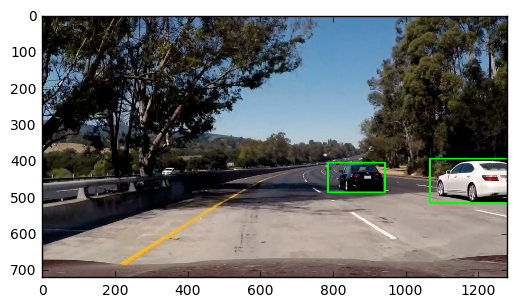

In [8]:
%matplotlib inline

def pipeline(image):
    image_data = cv2.resize(image,(416,416)).astype("float32")

    image_data /= 255.
    image_data = np.expand_dims(image_data, axis=0)

    sess = K.get_session()
    out_boxes, out_scores, out_classes = sess.run(
        [boxes, scores, classes],
        feed_dict={
            yolo_model.input: image_data,
            input_image_shape: [image.shape[0], image.shape[1]],
            K.learning_phase(): 0
        })

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        if predicted_class != 'car':
            continue

        box = out_boxes[i]
        score = out_scores[i]

        top, left, bottom, right = box
        cv2.rectangle(image,(left, top),(right, bottom),(0,255,0),3)
    return image



imagePath = './test_images/test5.jpg'
image = plt.imread(imagePath)

plt.imshow(pipeline(image))


In [9]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")

clip1_output = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [37:30<00:01,  1.79s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 37min 32s
